In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

**Base de Datos CIFAR-100**

CIFAR-100 es una extensión de la base de datos CIFAR-10, y al igual que su predecesora, es ampliamente utilizada en el campo de la visión por computadora y el aprendizaje automático. Algunas de las características clave de CIFAR-100 son las siguientes:

1. **Clases:** A diferencia de CIFAR-10, CIFAR-100 consta de 100 clases diferentes, cada una representando un tipo de objeto o escena que se encuentra comúnmente en imágenes. Las clases se agrupan en 20 superclases, y cada superclase contiene 5 clases. Esto proporciona un nivel adicional de desafío en la clasificación de imágenes.

2. **Imágenes:** El conjunto de datos CIFAR-100 contiene un total de 60,000 imágenes a color, que se dividen en 50,000 imágenes de entrenamiento y 10,000 imágenes de prueba. Cada imagen tiene un tamaño de 32x32 píxeles, al igual que en CIFAR-10.

3. **Estructura de Carpetas:** Al igual que en CIFAR-10, las imágenes se organizan en 100 carpetas diferentes (una para cada clase), y cada imagen se almacena en la carpeta correspondiente a su clase.

4. **Nivel de Dificultad:** Debido al mayor número de clases, CIFAR-100 se considera un conjunto de datos más desafiante que CIFAR-10. La clasificación precisa de 100 clases con imágenes de baja resolución presenta un desafío significativo.

5. **Aplicaciones:** CIFAR-100 se utiliza comúnmente en la evaluación y el desarrollo de algoritmos de clasificación de imágenes, particularmente aquellos relacionados con el aprendizaje profundo y las redes neuronales convolucionales (CNN). También se utiliza en investigaciones académicas y competencias.

6. **Superclases:** Algunas de las superclases de CIFAR-100 incluyen mamíferos, insectos, vehículos, electrodomésticos y más, lo que agrega una dimensión adicional a la clasificación.

7. **Objetivo:** El objetivo principal de CIFAR-100 es entrenar modelos de aprendizaje automático para clasificar correctamente las imágenes en una de las 100 clases o superclases.

CIFAR-100 es un conjunto de datos ampliamente reconocido y utilizado para tareas de clasificación de imágenes más avanzadas y desafiantes que CIFAR-10. Su diversidad de clases y la estructura de superclases lo convierten en una elección común para proyectos de visión por computadora y aprendizaje profundo.


In [2]:
SEED = 42
BATCH_SIZE = 32
TARGET_SIZE = 32
EPOCHS = 50

# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()


169001437/169001437 [==============================] - 3s 0us/step


In [3]:
# Define data augmentations
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input
)

datagen.fit(x_train)

# Load a pre-trained model for transfer learning
pretrained_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(TARGET_SIZE, TARGET_SIZE, 3)
)

# Freeze some layers of the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False


9406464/9406464 [==============================] - 1s 0us/step


In [4]:
# Create a new model for transfer learning
input = Input(shape=(TARGET_SIZE, TARGET_SIZE, 3))
x = preprocess_input(input)
x = pretrained_model(x)
x = Flatten()(x)
x = Dense(100, activation="relu")(x)  # 100 classes for CIFAR-100
output = Dense(100, activation="softmax")(x)  # 100 classes for CIFAR-100

model_tl = Model(input, output)

# Compile the transfer learning model
model_tl.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [5]:
# Load a pre-trained model for fine-tuning
pretrained_model_ft = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(TARGET_SIZE, TARGET_SIZE, 3)
)

# Define which layers to freeze for fine-tuning
layers_to_freeze = 100

# Freeze some layers up to the specified layer
for layer in pretrained_model_ft.layers[:layers_to_freeze]:
    layer.trainable = False

# Create a new model for fine-tuning
input_ft = Input(shape=(TARGET_SIZE, TARGET_SIZE, 3))
x_ft = preprocess_input(input_ft)
x_ft = pretrained_model_ft(x_ft)
x_ft = Flatten()(x_ft)
x_ft = Dense(100, activation="relu")(x_ft)  # 100 classes for CIFAR-100
output_ft = Dense(100, activation="softmax")(x_ft)  # 100 classes for CIFAR-100

model_ft = Model(input_ft, output_ft)

# Compile the fine-tuning model
model_ft.compile(
    optimizer=SGD(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [6]:
# Define callbacks for saving the best models and early stopping
def get_ckpt(ckpt_name):
    return ModelCheckpoint(
        ckpt_name,
        mode="max",
        save_best_only=True,
        monitor="val_accuracy",
        verbose=1
    )

# Checkpoints
autosave_tl = get_ckpt("classification_transfer_learning.h5")
autosave_ft = get_ckpt("classification_fine_tuning.h5")

# Early stopping
early_stopping = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode='max'
)

cbks_tl = [autosave_tl, early_stopping]
cbks_ft = [autosave_ft, early_stopping]


In [7]:
# Train the transfer learning model
history_tl = model_tl.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    callbacks=cbks_tl
)

# Train the fine-tuning model
history_ft = model_ft.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    callbacks=cbks_ft
)

Epoch 1/50
1562/1563 [============================>.] - ETA: 0s - loss: 4.5592 - accuracy: 0.0646
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to classification_transfer_learning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1563/1563 [==============================] - 88s 54ms/step - loss: 4.5592 - accuracy: 0.0646 - val_loss: 4.7156 - val_accuracy: 0.0000e+00
Epoch 2/50
1562/1563 [============================>.] - ETA: 0s - loss: 4.4230 - accuracy: 1.2008e-04
Epoch 2: val_accuracy improved from 0.00000 to 0.00010, saving model to classification_transfer_learning.h5
1563/1563 [==============================] - 76s 49ms/step - loss: 4.4230 - accuracy: 1.2000e-04 - val_loss: 4.8954 - val_accuracy: 1.0000e-04
Epoch 3/50
1563/1563 [==============================] - ETA: 0s - loss: 4.3653 - accuracy: 0.0044
Epoch 3: val_accuracy did not improve from 0.00010
1563/1563 [==============================] - 78s 50ms/step - loss: 4.3653 - accuracy: 0.0044 - val_loss: 5.0184 - val_accuracy: 0.0000e+00
Epoch 4/50
1562/1563 [============================>.] - ETA: 0s - loss: 4.3326 - accuracy: 0.0037
Epoch 4: val_accuracy did not improve from 0.00010
1563/1563 [==============================] - 75s 48ms/step - loss: 4.33

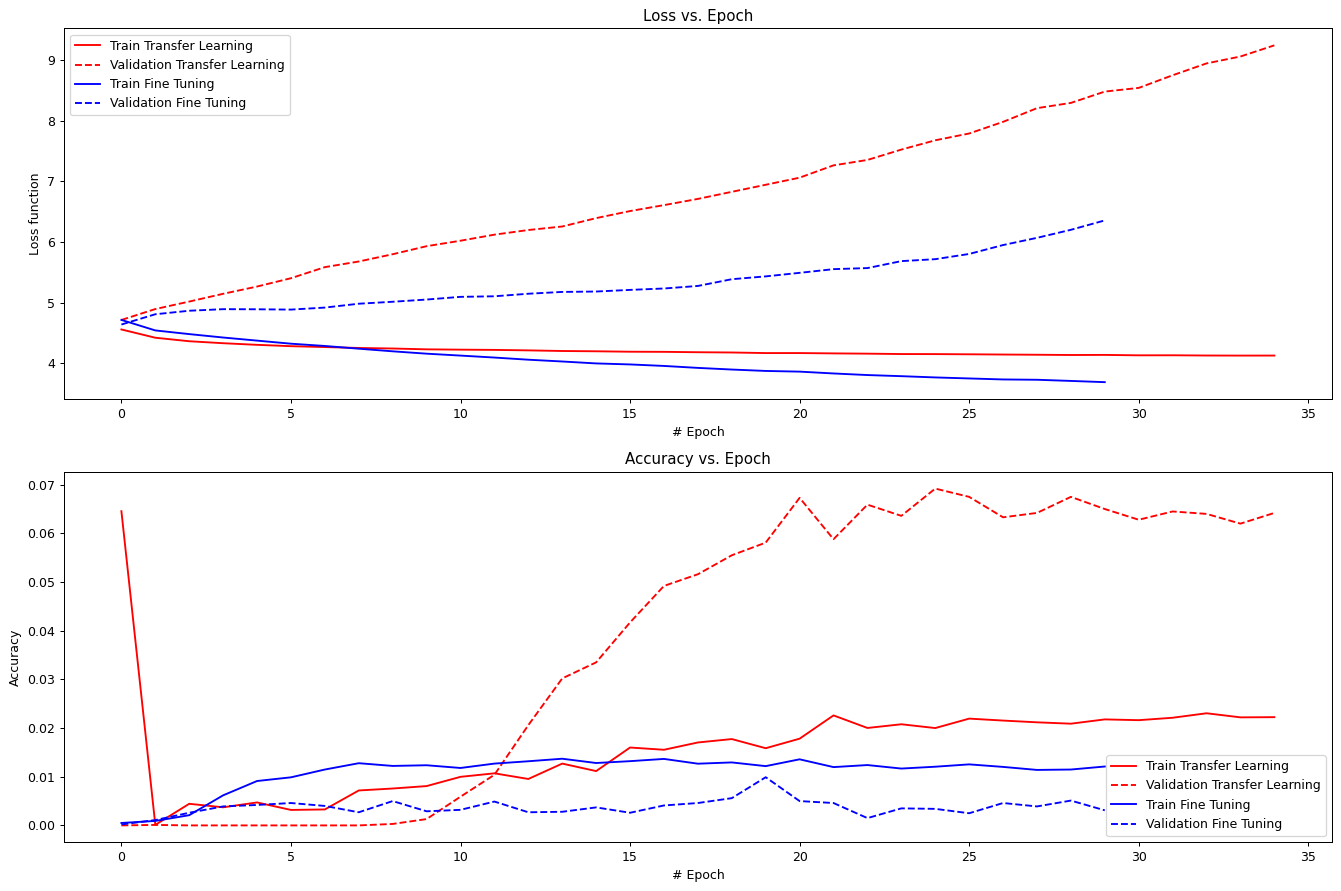

In [8]:
# Visualize training history (loss and accuracy)
fig_labels = ["Train Transfer Learning", "Validation Transfer Learning", "Train Fine Tuning", "Validation Fine Tuning"]

plt.figure(figsize=(15, 10), dpi=90)

plt.subplot(2, 1, 1)
plt.plot(history_tl.history["loss"], "r-")
plt.plot(history_tl.history["val_loss"], "r--")
plt.plot(history_ft.history["loss"], "b-")
plt.plot(history_ft.history["val_loss"], "b--")
plt.xlabel("# Epoch")
plt.ylabel("Loss function")
plt.legend(fig_labels)
plt.title("Loss vs. Epoch")

plt.subplot(2, 1, 2)
plt.plot(history_tl.history["accuracy"], "r-")
plt.plot(history_tl.history["val_accuracy"], "r--")
plt.plot(history_ft.history["accuracy"], "b-")
plt.plot(history_ft.history["val_accuracy"], "b--")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(fig_labels)
plt.title("Accuracy vs. Epoch")

plt.tight_layout()
plt.show()

In [11]:
# Evaluate models on training, validation, and test sets
scores_train_tl = model_tl.evaluate(x_train, y_train, verbose=0)
scores_train_ft = model_ft.evaluate(x_train, y_train, verbose=0)

scores_val_tl = model_tl.evaluate(x_test, y_test, verbose=0)
scores_val_ft = model_ft.evaluate(x_test, y_test, verbose=0)

scores_test_tl = model_tl.evaluate(x_test, y_test, verbose=0)
scores_test_ft = model_ft.evaluate(x_test, y_test, verbose=0)

print("Training - Transfer Learning:")
print(f"Loss: {scores_train_tl[0]}, Accuracy: {scores_train_tl[1]}")

print("Training - Fine Tuning:")
print(f"Loss: {scores_train_ft[0]}, Accuracy: {scores_train_ft[1]}")

print("Validation - Transfer Learning:")
print(f"Loss: {scores_val_tl[0]}, Accuracy: {scores_val_tl[1]}")

print("Validation - Fine Tuning:")
print(f"Loss: {scores_val_ft[0]}, Accuracy: {scores_val_ft[1]}")

print("Test - Transfer Learning:")
print(f"Loss: {scores_test_tl[0]}, Accuracy: {scores_test_tl[1]}")

print("Test - Fine Tuning:")
print(f"Loss: {scores_test_ft[0]}, Accuracy: {scores_test_ft[1]}")


Training - Transfer Learning:
Loss: 9.34887981414795, Accuracy: 0.06605999916791916
Training - Fine Tuning:
Loss: 6.374348163604736, Accuracy: 0.0031399999279528856
Validation - Transfer Learning:
Loss: 9.23759937286377, Accuracy: 0.06419999897480011
Validation - Fine Tuning:
Loss: 6.355015277862549, Accuracy: 0.003100000089034438
Test - Transfer Learning:
Loss: 9.23759937286377, Accuracy: 0.06419999897480011
Test - Fine Tuning:
Loss: 6.355015277862549, Accuracy: 0.003100000089034438
